In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import libpysal as lps
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import KernelDensity

import matplotlib.dates as mdates

In [2]:
# read zipfile
df = pd.read_csv('data/data_selection_17_23.csv')

In [3]:
df['dt']=pd.to_datetime(df['timestamp'], unit='s')    
df['datetime'] = df['dt'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [386]:
# start label df 
df['anomaly_temperature']=False
df['anomaly_humidity']=False    
df['anomaly_voltage']=False
df['anomaly_light']=False


In [387]:
# all temperature above 30 is anomaly
df.loc[df['temperature']>38,'anomaly_temperature']=True
# all temperature below 10 is anomaly
df.loc[df['temperature']<10,'anomaly_temperature']=True
# all missing temperature is anomaly
# df.loc[df['temperature'].isnull(),'anomaly_temperature']=True
# node 4 after 7500 is anomaly
df.loc[(df['nodeid']==4),'anomaly_temperature'][7500:]=True
# node 6 after 7500 is anomaly
df.loc[(df['nodeid']==6),'anomaly_temperature'][7500:]=True
# node 13 after 14000 is anomaly
df.loc[(df['nodeid']==13),'anomaly_temperature'][14000:]=True
# node 15 is anomaly
df.loc[(df['nodeid']==15),'anomaly_temperature']=True
# node 16 is anomaly
df.loc[(df['nodeid']==16),'anomaly_temperature']=True
# node 17 is anomaly
df.loc[(df['nodeid']==17),'anomaly_temperature']=True
# node 18 is anomaly
df.loc[(df['nodeid']==18),'anomaly_temperature']=True
# node 19 after 7500 is anomaly
df.loc[(df['nodeid']==19),'anomaly_temperature'][7500:]=True
# node 19 first 2000 is anomaly
df.loc[np.logical_and(df['nodeid']==19,df.index<=107964),'anomaly_temperature']=True
# node 20 is anomaly
df.loc[(df['nodeid']==20),'anomaly_temperature']=True
# node 21 after 14000 is anomaly
df.loc[(df['nodeid']==21),'anomaly_temperature'][14000:]=True
# node 27 has anomaly from 14500 to 15000 where temperature >20.50
select_node=df.loc[df['nodeid']==27,'temperature'][14500:15000]
df.loc[(select_node[select_node>20.50]).index,'anomaly_temperature']=True
# node 35 after 7500 is anomaly
df.loc[(df['nodeid']==35),'anomaly_temperature'][7500:]=True
# node 40 / index 905079 is anomaly
df.loc[905079,'anomaly_temperature']=True
# node 46 after 13500 is anomaly
df.loc[(df['nodeid']==46),'anomaly_temperature'][13500]=True

# if temperature is NaN, then it is not anomaly
df.loc[df['temperature'].isnull(),'anomaly_temperature']=False


In [534]:
# label humidity
# all humidity above 100 is anomaly
df.loc[df['humidity']>100,'anomaly_humidity']=True
# node 6 after 583234 is anomaly
df.loc[np.logical_and(df['nodeid']==6,df.index>583234),'anomaly_humidity']=True
# all humidity below 20 is anomaly
df.loc[df['humidity']<20,'anomaly_humidity']=True
# node 16 is anomaly
df.loc[(df['nodeid']==16),'anomaly_humidity']=True
# node 17 is anomaly
df.loc[(df['nodeid']==17),'anomaly_humidity']=True
# node 19 after index 464256 is anomaly
df.loc[np.logical_and(df['nodeid']==19,df.index>464256),'anomaly_humidity']=True
# node 35 after 583234 is anomaly
df.loc[np.logical_and(df['nodeid']==35,df.index>583234),'anomaly_humidity']=True


# if temperature is NaN, then it is not anomaly
df.loc[df['humidity'].isnull(),'anomaly_humidity']=False

In [527]:
df.loc[df['nodeid']==35][10800:]


,timestamp,nodeid,temperature,humidity,voltage,light,anomaly_temperature,anomaly_humidity,anomaly_voltage,anomaly_light
583234,1792800,35,NaN,NaN,NaN,NaN,False,False,False,False
583288,1792830,35,122.153,43.519,2.29313,172.96,True,True,False,False
583342,1792860,35,NaN,NaN,NaN,NaN,False,False,False,False
583396,1792890,35,122.153,43.519,2.29313,172.96,True,True,False,False
583450,1792920,35,NaN,NaN,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
932884,1987050,35,NaN,NaN,NaN,NaN,False,False,False,False
932938,1987080,35,NaN,NaN,NaN,NaN,False,False,False,False
932992,1987110,35,NaN,NaN,NaN,NaN,False,False,False,False
933046,1987140,35,NaN,NaN,NaN,NaN,False,False,False,False


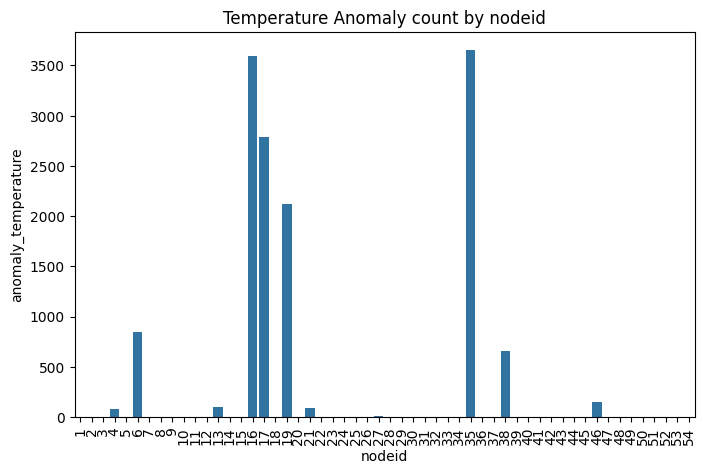

In [395]:
# plot anomaly count by node id
plt.figure(figsize=(8,5))
sns.barplot(x='nodeid', y='anomaly_temperature', data=df.groupby('nodeid')['anomaly_temperature'].sum().reset_index())
plt.title('Temperature Anomaly count by nodeid')
# rotate the x-axis
plt.xticks(rotation=90)
plt.show()

In [544]:
# save df
# drop column dt and datetime
# df.drop(columns=['dt','datetime'],inplace=True)
df.to_csv('./data/manual_label.csv',index=False)

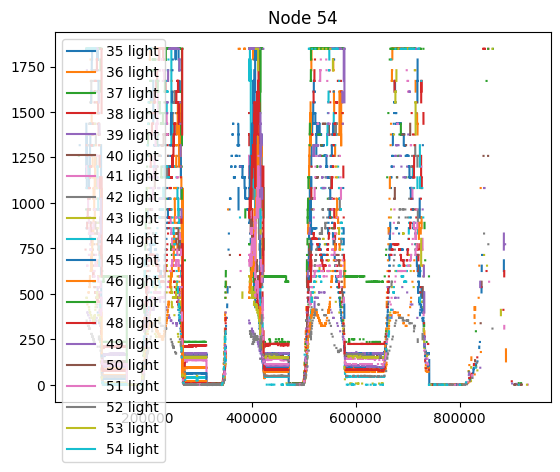

In [542]:
# show temperature by nodeid

for idx in range(35,55):
    # plt.figure(figsize=(5,3))
    data=df[df['nodeid']==idx]
    # filter out the anomaly data
    # anomaly_data = data[data['anomaly_humidity']==True]
    # anomaly_data['humidity'].plot(style='r.')
    data['light'].plot(label=f'{idx} light')
    
    plt.legend(loc='upper left')
    plt.title('Node '+str(idx))

    # don't show x-axis
    # plt.xticks([])
    # plt.xticks(rotation=45)
    # plt.show()

In [410]:
# group by nodeid and anomaly_temperature and count the size, 
df_an=df[df['anomaly_temperature']==True]
df_an.groupby(['nodeid','anomaly_temperature']).size().unstack().sort_values(by=True,ascending=False)

anomaly_temperature,True
nodeid,
35,3651
16,3596
17,2785
19,2119
6,849
38,658
46,153
13,101
21,85


In [545]:
# group by nodeid and anomaly_temperature and count the size, 
df_an=df[df['anomaly_humidity']==True]
df_an.groupby(['nodeid','anomaly_humidity']).size().unstack().sort_values(by=True,ascending=False)

anomaly_humidity,True
nodeid,
16,3596
17,2785
19,2073
35,2072
6,569
26,1
32,1
39,1
43,1
